# 🔬 Semi-Supervised Object Detection: Pseudo-Labelling with YOLOv12

**Assignment 2: Semi-Supervised Learning for Brain MRI Detection**

This notebook implements a comprehensive Semi-Supervised Object Detection (SSOD) pipeline using **Pseudo-Labelling** with **YOLOv12**, leveraging pre-trained weights from Assignment 1.

---

## 📋 Pipeline Overview

| # | Step | Description | Output |
|---|------|-------------|--------|
| **1** | Environment Setup | Install ultralytics, configure GPU, set random seeds | Ready environment |
| **2** | Data Configuration | Load Brain MRI dataset, configure paths and classes | Dataset YAML |
| **3** | Load Pre-trained YOLOv12 | Load weights from Assignment 1 (`best.pt`) | Base model |
| **4** | Semi-Supervised Setup | Split data into labeled (20%) and unlabeled (80%) | Train splits |
| **5** | Teacher Training | Fine-tune YOLOv12 on labeled subset | Teacher weights |
| **6** | Pseudo-Label Generation | Generate high-confidence predictions on unlabeled data (τ≥0.7) | Pseudo-labels |
| **7** | Student Training | Train on combined GT + pseudo-labels | Student weights |
| **8** | Evaluation | Compute mAP, precision, recall, confusion matrix | Metrics |
| **9** | Visualization | Predictions with bounding boxes & detection counts | Visual results |

---

## 📚 Table of Contents
1. [Introduction & Theory](#1-introduction--theory)
2. [Environment Setup](#2-environment-setup)
3. [Data Configuration](#3-data-configuration)
4. [Baseline Model (Fully Supervised)](#4-baseline-model-fully-supervised)
5. [Semi-Supervised Setup](#5-semi-supervised-setup)
6. [Phase 1: Teacher Model Training](#6-phase-1-teacher-model-training)
7. [Phase 2: Pseudo-Label Generation](#7-phase-2-pseudo-label-generation)
8. [Phase 3: Student Model Training](#8-phase-3-student-model-training)
9. [Comprehensive Evaluation & Metrics](#9-comprehensive-evaluation--metrics)
10. [Visualization & Analysis](#10-visualization--analysis)
11. [Conclusion](#11-conclusion)

---

## 1. Introduction & Theory

### Semi-Supervised Learning (SSL)
SSL leverages both **labeled** and **unlabeled** data to improve model performance. This is particularly valuable in medical imaging where annotation is expensive.

### Pseudo-Labelling Approach
1. **Teacher Training**: Train a model on labeled data
2. **Pseudo-Label Generation**: Use teacher to predict labels for unlabeled data
3. **Confidence Filtering**: Only keep high-confidence predictions
4. **Student Training**: Train on combined labeled + pseudo-labeled data

```
┌─────────────────┐    ┌──────────────────┐    ┌─────────────────┐
│  Labeled Data   │───▶│  Teacher Model   │───▶│ Pseudo Labels   │
│    (20%)        │    │                  │    │                 │
└─────────────────┘    └──────────────────┘    └────────┬────────┘
                                                        │
                       ┌──────────────────┐             │
                       │  Student Model   │◀────────────┘
                       │ (Labeled+Pseudo) │
                       └──────────────────┘
```

## 2. Environment Setup

In [1]:
# CELL 2: Lock NumPy and rebuild scipy
import numpy as np
print(f"✅ Initial NumPy: {np.__version__}")

# Install packages without dependencies first
%pip install -q --no-deps ultralytics matplotlib seaborn pandas pyyaml tqdm scikit-learn

# Force numpy to 1.26.4 and rebuild scipy
%pip uninstall -y scipy
%pip install -q "numpy==1.26.4" "scipy<1.15"

# Reinstall opencv with older version compatible with numpy 1.x
%pip install -q "opencv-python==4.8.0.74"

print("⚠️  MUST RESTART RUNTIME NOW")
print("⚠️  Click: Runtime → Restart session")
print("⚠️  Then run Cell 3 below")


✅ Initial NumPy: 1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 43.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.237 requires ultralytics-thop>=2.0.18, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, b

In [2]:
# CELL 3: Import libraries after restart
%pip install -q --no-deps ultralytics
import numpy as np
print(f"✅ NumPy: {np.__version__}")

import os
import shutil
import random
import yaml
import pandas as pd
import matplotlib.pyplot as plt

# Try seaborn, skip if broken
try:
    import seaborn as sns
    sns.set_palette('husl')
    print("✅ Seaborn loaded")
except Exception as e:
    print(f"⚠️ Seaborn unavailable: {e}")
    sns = None

from pathlib import Path
from tqdm import tqdm
from collections import Counter
import cv2
from PIL import Image, ImageDraw, ImageFont
import warnings
warnings.filterwarnings('ignore')

from ultralytics import YOLO

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️ Using device: {device}")
if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\n✅ All critical libraries imported!")


Note: you may need to restart the kernel to use updated packages.
✅ NumPy: 1.26.4
✅ Seaborn loaded
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🖥️ Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB

✅ All critical libraries imported!


## 3. Data Configuration

In [3]:
# ============================================
# 🔧 CONFIGURATION
# ============================================

IS_KAGGLE = os.path.exists('/kaggle/input')

# =============================================
# PATH CONFIGURATION (Kaggle vs Local)
# =============================================
if IS_KAGGLE:
    # Kaggle paths - upload brain-mri-split-dataset-v2 as dataset
    DATASET_NAME = 'brain-mri-split-dataset-v2/brain-mri-split-dataset-v2'
    BASE_DIR = Path(f'/kaggle/input/{DATASET_NAME}/dataset')
    DATA_YAML = Path(f'/kaggle/input/{DATASET_NAME}/data.yaml')
    # YOLOv12 pre-trained weights included in dataset
    YOLOV12_WEIGHTS = Path('/kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/yolov12-best.pt')
else:
    # Local paths
    BASE_DIR = Path('/kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset')
    DATA_YAML = Path('/kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/data.yaml')
    YOLOV12_WEIGHTS = Path('/kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/yolov12-best.pt')

# Experiment directories
EXPERIMENT_DIR = Path('/kaggle/working/ssod_yolov12' if IS_KAGGLE else 'ssod_experiment')
EXPERIMENT_DIR.mkdir(exist_ok=True, parents=True)

# =============================================
# HYPERPARAMETERS (STAC-style)
# =============================================
LABELED_RATIO = 0.20          # 20% labeled, 80% unlabeled simulation
CONF_THRESHOLD = 0.70         # Confidence threshold for pseudo-labels (τ=0.7 like teacher's example)
IOU_THRESHOLD = 0.45          # IoU threshold for NMS
EPOCHS_TEACHER = 100           # Epochs for teacher model
EPOCHS_STUDENT = 100           # Epochs for student model
EPOCHS_BASELINE = 100          # Epochs for baseline comparison
IMG_SIZE = 640                # Image size
BATCH_SIZE = 16               # Batch size
RANDOM_SEED = 42

# Set random seeds
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Class names
with open(DATA_YAML, 'r') as f:
    data_config = yaml.safe_load(f)
CLASS_NAMES = data_config['names']
NUM_CLASSES = len(CLASS_NAMES)

print("=" * 70)
print("📊 SSOD CONFIGURATION (YOLOv12 + STAC-Style Pseudo-Labelling)")
print("=" * 70)
print(f"  📍 Environment:       {'🌐 Kaggle' if IS_KAGGLE else '💻 Local'}")
print(f"  📂 Dataset:           {BASE_DIR}")
print(f"  🏷️  Classes:           {CLASS_NAMES}")
print(f"  🔧 YOLOv12 Weights:   {YOLOV12_WEIGHTS}")
print(f"  📊 Labeled Ratio:     {LABELED_RATIO*100:.0f}%")
print(f"  🎯 Confidence τ:      {CONF_THRESHOLD}")
print(f"  🖼️  Image Size:        {IMG_SIZE}")
print("=" * 70)

# Verify YOLOv12 weights exist
if YOLOV12_WEIGHTS.exists():
    print(f"\n✅ YOLOv12 weights found: {YOLOV12_WEIGHTS}")
else:
    print(f"\n⚠️  YOLOv12 weights not found at {YOLOV12_WEIGHTS}")
    print("   Will use yolo11n.pt as fallback")
    YOLOV12_WEIGHTS = 'yolo11n.pt'


📊 SSOD CONFIGURATION (YOLOv12 + STAC-Style Pseudo-Labelling)
  📍 Environment:       🌐 Kaggle
  📂 Dataset:           /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset
  🏷️  Classes:           ['cct', 'ifc', 'uas']
  🔧 YOLOv12 Weights:   /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/yolov12-best.pt
  📊 Labeled Ratio:     20%
  🎯 Confidence τ:      0.7
  🖼️  Image Size:        640

✅ YOLOv12 weights found: /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/yolov12-best.pt


## 4. Baseline Model (Fully Supervised)

First, we train a baseline model using **all** labeled data to establish an upper bound.

In [4]:
# ============================================
# Fix data.yaml with correct paths
# ============================================
print("🔧 Creating corrected data.yaml file...")

# Define correct paths for Kaggle environment
corrected_yaml_content = f"""
path: /kaggle/input/{DATASET_NAME}/dataset
train: train/images
val: valid/images
test: test/images

names: {CLASS_NAMES}
nc: {NUM_CLASSES}
"""

# Save corrected yaml to working directory
CORRECTED_DATA_YAML = EXPERIMENT_DIR / 'data_corrected.yaml'
with open(CORRECTED_DATA_YAML, 'w') as f:
    f.write(corrected_yaml_content.strip())

print(f"✅ Corrected data.yaml created at: {CORRECTED_DATA_YAML}")

# Verify paths exist
train_path = Path(f'/kaggle/input/{DATASET_NAME}/dataset/train/images')
val_path = Path(f'/kaggle/input/{DATASET_NAME}/dataset/valid/images')

if train_path.exists():
    print(f"✅ Training images found: {len(list(train_path.glob('*.jpg')))} images")
else:
    print(f"⚠️  Training path not found: {train_path}")

if val_path.exists():
    print(f"✅ Validation images found: {len(list(val_path.glob('*.jpg')))} images")
else:
    print(f"⚠️  Validation path not found: {val_path}")


🔧 Creating corrected data.yaml file...
✅ Corrected data.yaml created at: /kaggle/working/ssod_yolov12/data_corrected.yaml
✅ Training images found: 1810 images
✅ Validation images found: 226 images


In [5]:
# ============================================
# Train Baseline Model (100% Labeled Data)
# ============================================
print("="*70)
print("📈 BASELINE MODEL: Training on 100% labeled data")
print("="*70)

baseline_model = YOLO(str(YOLOV12_WEIGHTS))

baseline_results = baseline_model.train(
    data=str(CORRECTED_DATA_YAML),  # Use corrected yaml
    epochs=EPOCHS_BASELINE,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name='baseline_model',
    project=str(EXPERIMENT_DIR),
    verbose=True,
    device=0 if device == 'cuda' else 'cpu',  # Use GPU if available
    workers=4  # Enable dataloader workers for faster training
)

print("\n✅ Baseline training complete!")

📈 BASELINE MODEL: Training on 100% labeled data
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/ssod_yolov12/data_corrected.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/yolov12-best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name

In [6]:
# Evaluate baseline on test set
print("\n📊 Baseline Model Evaluation:")
baseline_metrics = baseline_model.val(data=str(CORRECTED_DATA_YAML), split='test')
print(f"  Test mAP50: {baseline_metrics.box.map50:.4f}")
print(f"  Test mAP50-95: {baseline_metrics.box.map:.4f}")



📊 Baseline Model Evaluation:
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 11.8±2.0 MB/s, size: 37.2 KB)
val: Scanning /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset/test/labels... 227 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 227/227 332.2it/s 0.7s
WARNING ⚠️ val: Cache directory /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 4.7it/s 3.2s
                   all        227        243      0.847      0.866       0.93      0.646
                   cct        126        134      0.836      0.888      0.952      0.643
                   ifc         76         83       0.82      0.831      0.919      0.647
          

## 5. Semi-Supervised Setup

Simulate semi-supervised scenario by splitting training data into labeled and unlabeled portions.

In [7]:
# Setup directories for SSL experiment
SSL_DIR = EXPERIMENT_DIR / 'ssl_data'
LABELED_DIR = SSL_DIR / 'labeled'
UNLABELED_DIR = SSL_DIR / 'unlabeled'
PSEUDO_DIR = SSL_DIR / 'pseudo_labeled'

for d in [LABELED_DIR, UNLABELED_DIR, PSEUDO_DIR]:
    (d / 'images').mkdir(parents=True, exist_ok=True)
    (d / 'labels').mkdir(parents=True, exist_ok=True)

# Get all training images
TRAIN_IMG_DIR = BASE_DIR / 'train' / 'images'
TRAIN_LBL_DIR = BASE_DIR / 'train' / 'labels'
all_train_images = list(TRAIN_IMG_DIR.glob('*.jpg')) + list(TRAIN_IMG_DIR.glob('*.png'))

# Shuffle and split
random.seed(RANDOM_SEED)
random.shuffle(all_train_images)

num_labeled = int(len(all_train_images) * LABELED_RATIO)
labeled_images = all_train_images[:num_labeled]
unlabeled_images = all_train_images[num_labeled:]

print("📊 SEMI-SUPERVISED DATA SPLIT:")
print(f"  Total Training Images: {len(all_train_images)}")
print(f"  Labeled Images (Teacher): {len(labeled_images)} ({LABELED_RATIO*100:.0f}%)")
print(f"  Unlabeled Images: {len(unlabeled_images)} ({(1-LABELED_RATIO)*100:.0f}%)")

📊 SEMI-SUPERVISED DATA SPLIT:
  Total Training Images: 1810
  Labeled Images (Teacher): 362 (20%)
  Unlabeled Images: 1448 (80%)


In [8]:
# Setup directories for SSL experiment
SSL_DIR = EXPERIMENT_DIR / 'ssl_data'
LABELED_DIR = SSL_DIR / 'labeled'
UNLABELED_DIR = SSL_DIR / 'unlabeled'
PSEUDO_DIR = SSL_DIR / 'pseudo_labeled'

for d in [LABELED_DIR, UNLABELED_DIR, PSEUDO_DIR]:
    (d / 'images').mkdir(parents=True, exist_ok=True)
    (d / 'labels').mkdir(parents=True, exist_ok=True)

# Get all training images
TRAIN_IMG_DIR = BASE_DIR / 'train' / 'images'
TRAIN_LBL_DIR = BASE_DIR / 'train' / 'labels'
all_train_images = list(TRAIN_IMG_DIR.glob('*.jpg')) + list(TRAIN_IMG_DIR.glob('*.png'))

# Shuffle and split
random.seed(RANDOM_SEED)
random.shuffle(all_train_images)

num_labeled = int(len(all_train_images) * LABELED_RATIO)
labeled_images = all_train_images[:num_labeled]
unlabeled_images = all_train_images[num_labeled:]

print("📊 SEMI-SUPERVISED DATA SPLIT:")
print(f"  Total Training Images: {len(all_train_images)}")
print(f"  Labeled Images (Teacher): {len(labeled_images)} ({LABELED_RATIO*100:.0f}%)")
print(f"  Unlabeled Images: {len(unlabeled_images)} ({(1-LABELED_RATIO)*100:.0f}%)")

# Copy labeled data
print("\n📁 Copying labeled data...")
for img_path in tqdm(labeled_images, desc="Labeled"):
    shutil.copy2(img_path, LABELED_DIR / 'images' / img_path.name)
    lbl_path = TRAIN_LBL_DIR / (img_path.stem + '.txt')
    if lbl_path.exists():
        shutil.copy2(lbl_path, LABELED_DIR / 'labels' / lbl_path.name)

# Copy unlabeled images (no labels)
print("📁 Copying unlabeled images...")
for img_path in tqdm(unlabeled_images, desc="Unlabeled"):
    shutil.copy2(img_path, UNLABELED_DIR / 'images' / img_path.name)

# ============================================
# FIXED YAML CREATION
# ============================================

# Create proper validation directory structure
VAL_DIR = SSL_DIR / 'validation'
(VAL_DIR / 'images').mkdir(parents=True, exist_ok=True)
(VAL_DIR / 'labels').mkdir(parents=True, exist_ok=True)

# Copy validation data from original dataset
print("📁 Copying validation data...")
orig_val_img = BASE_DIR / 'valid' / 'images'  # Kaggle uses 'valid' not 'val'
orig_val_lbl = BASE_DIR / 'valid' / 'labels'

if not orig_val_img.exists():
    orig_val_img = BASE_DIR / 'val' / 'images'  # Try 'val' as fallback
    orig_val_lbl = BASE_DIR / 'val' / 'labels'

for img_path in tqdm(list(orig_val_img.glob('*')), desc="Validation"):
    shutil.copy2(img_path, VAL_DIR / 'images' / img_path.name)
    lbl_path = orig_val_lbl / (img_path.stem + '.txt')
    if lbl_path.exists():
        shutil.copy2(lbl_path, VAL_DIR / 'labels' / lbl_path.name)

# Create YAML with correct structure (path + relative paths)
labeled_yaml = {
    'path': str(SSL_DIR),           # Root directory
    'train': 'labeled/images',       # Relative to path
    'val': 'validation/images',      # Relative to path
    'nc': NUM_CLASSES,
    'names': CLASS_NAMES
}

LABELED_YAML_PATH = EXPERIMENT_DIR / 'labeled_only.yaml'
with open(LABELED_YAML_PATH, 'w') as f:
    yaml.dump(labeled_yaml, f, default_flow_style=False)

print(f"\n✅ Created labeled-only config: {LABELED_YAML_PATH}")
print(f"  📊 Training images: {len(list((LABELED_DIR / 'images').glob('*')))}")
print(f"  📊 Validation images: {len(list((VAL_DIR / 'images').glob('*')))}")

print("\n📝 YAML Contents:")
with open(LABELED_YAML_PATH, 'r') as f:
    print(f.read())


📊 SEMI-SUPERVISED DATA SPLIT:
  Total Training Images: 1810
  Labeled Images (Teacher): 362 (20%)
  Unlabeled Images: 1448 (80%)

📁 Copying labeled data...


Labeled: 100%|██████████| 362/362 [00:01<00:00, 338.77it/s]


📁 Copying unlabeled images...


Unlabeled: 100%|██████████| 1448/1448 [00:01<00:00, 1306.87it/s]


📁 Copying validation data...


Validation: 100%|██████████| 226/226 [00:00<00:00, 356.56it/s]


✅ Created labeled-only config: /kaggle/working/ssod_yolov12/labeled_only.yaml
  📊 Training images: 362
  📊 Validation images: 226

📝 YAML Contents:
names:
- cct
- ifc
- uas
nc: 3
path: /kaggle/working/ssod_yolov12/ssl_data
train: labeled/images
val: validation/images



## 6. Phase 1: Teacher Model Training (Using YOLOv12 Pre-trained Weights)

Train the teacher model on the small labeled subset (20%), starting from our pre-trained YOLOv12 weights from Assignment 1.

In [9]:
print("\n" + "="*60)
print("🎓 PHASE 1: TEACHER MODEL TRAINING (YOLOv12)")
print(f"   Starting from: {YOLOV12_WEIGHTS}")
print(f"   Training on {len(labeled_images)} labeled images ({LABELED_RATIO*100:.0f}%)")
print("="*60)

# Load YOLOv12 pre-trained weights from Assignment 1
teacher_model = YOLO(str(YOLOV12_WEIGHTS))

teacher_results = teacher_model.train(
    data=str(LABELED_YAML_PATH),
    epochs=EPOCHS_TEACHER,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    project=str(EXPERIMENT_DIR),
    name='teacher_yolov12',
    verbose=True,
    patience=10,
    save=True,
    plots=True,
    device=0 if device == 'cuda' else 'cpu',  # Use GPU if available
    workers=4  # Enable dataloader workers for faster training
)

# Save teacher weights path for later use
TEACHER_WEIGHTS = EXPERIMENT_DIR / 'teacher_yolov12' / 'weights' / 'best.pt'

print("\n✅ Teacher model training complete!")
print(f"📁 Model saved at: {TEACHER_WEIGHTS}")


🎓 PHASE 1: TEACHER MODEL TRAINING (YOLOv12)
   Starting from: /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/yolov12-best.pt
   Training on 362 labeled images (20%)
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/ssod_yolov12/labeled_only.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model

In [10]:
# Evaluate teacher model
print("\n📊 Teacher Model Evaluation:")
teacher_val_metrics = teacher_model.val(data=str(LABELED_YAML_PATH), split='val')
print(f"  Validation mAP50: {teacher_val_metrics.box.map50:.4f}")
print(f"  Validation mAP50-95: {teacher_val_metrics.box.map:.4f}")


📊 Teacher Model Evaluation:
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 913.2±295.1 MB/s, size: 34.5 KB)
val: Scanning /kaggle/working/ssod_yolov12/ssl_data/validation/labels.cache... 226 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 226/226 529.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 4.5it/s 3.4s
                   all        226        238      0.688      0.788      0.812      0.542
                   cct        117        123      0.692      0.675      0.758      0.491
                   ifc         79         85      0.524      0.953       0.81      0.543
                   uas         30         30      0.847      0.736      0.869      0.591
Speed: 1.8ms preprocess, 6.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results s

## 7. Phase 2: Pseudo-Label Generation

Use the trained teacher to generate pseudo-labels for unlabeled data.

In [11]:
print("="*60)
print("🏷️ PHASE 2: PSEUDO-LABEL GENERATION")
print(f"   Processing {len(unlabeled_images)} unlabeled images")
print(f"   Confidence threshold: {CONF_THRESHOLD}")
print("="*60)

# Statistics tracking
pseudo_stats = {
    'total_images': 0,
    'images_with_detections': 0,
    'total_detections': 0,
    'detections_per_class': Counter(),
    'confidence_scores': []
}

# Process unlabeled images
unlabeled_img_paths = list((UNLABELED_DIR / 'images').glob('*'))

for img_path in tqdm(unlabeled_img_paths, desc="Generating pseudo-labels"):
    pseudo_stats['total_images'] += 1
    
    # Run inference
    results = teacher_model.predict(
        source=str(img_path),
        conf=CONF_THRESHOLD,
        iou=IOU_THRESHOLD,
        verbose=False
    )
    
    boxes = results[0].boxes
    
    if len(boxes) > 0:
        pseudo_stats['images_with_detections'] += 1
        pseudo_stats['total_detections'] += len(boxes)
        
        # Save pseudo-labels in YOLO format
        label_path = PSEUDO_DIR / 'labels' / (img_path.stem + '.txt')
        with open(label_path, 'w') as f:
            for box in boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                x, y, w, h = box.xywhn[0].tolist()
                
                f.write(f"{cls_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
                
                pseudo_stats['detections_per_class'][cls_id] += 1
                pseudo_stats['confidence_scores'].append(conf)
        
        # Copy image to pseudo-labeled directory
        shutil.copy2(img_path, PSEUDO_DIR / 'images' / img_path.name)

print("\n📊 PSEUDO-LABEL STATISTICS:")
print(f"  Total unlabeled images: {pseudo_stats['total_images']}")
print(f"  Images with detections: {pseudo_stats['images_with_detections']}")
print(f"  Total pseudo-labels generated: {pseudo_stats['total_detections']}")
print(f"  Average confidence: {np.mean(pseudo_stats['confidence_scores']):.4f}")
print(f"  Detections per class:")
for cls_id, count in sorted(pseudo_stats['detections_per_class'].items()):
    print(f"    {CLASS_NAMES[cls_id]}: {count}")

🏷️ PHASE 2: PSEUDO-LABEL GENERATION
   Processing 1448 unlabeled images
   Confidence threshold: 0.7


Generating pseudo-labels: 100%|██████████| 1448/1448 [00:25<00:00, 56.38it/s]


📊 PSEUDO-LABEL STATISTICS:
  Total unlabeled images: 1448
  Images with detections: 846
  Total pseudo-labels generated: 899
  Average confidence: 0.8806
  Detections per class:
    cct: 196
    ifc: 606
    uas: 97


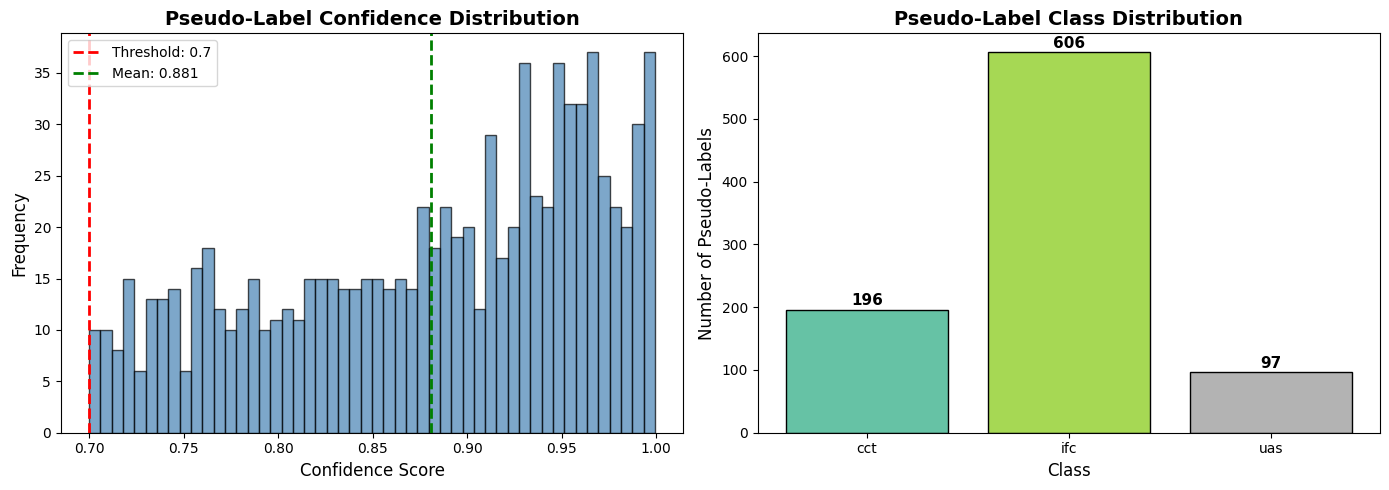

In [12]:
# Visualize pseudo-label confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence histogram
axes[0].hist(pseudo_stats['confidence_scores'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(CONF_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold: {CONF_THRESHOLD}')
axes[0].axvline(np.mean(pseudo_stats['confidence_scores']), color='green', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(pseudo_stats["confidence_scores"]):.3f}')
axes[0].set_xlabel('Confidence Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Pseudo-Label Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()

# Class distribution
class_labels = [CLASS_NAMES[i] for i in sorted(pseudo_stats['detections_per_class'].keys())]
class_values = [pseudo_stats['detections_per_class'][i] for i in sorted(pseudo_stats['detections_per_class'].keys())]
colors = plt.cm.Set2(np.linspace(0, 1, len(class_labels)))

bars = axes[1].bar(class_labels, class_values, color=colors, edgecolor='black')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Pseudo-Labels', fontsize=12)
axes[1].set_title('Pseudo-Label Class Distribution', fontsize=14, fontweight='bold')
for bar, val in zip(bars, class_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, str(val),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(str(EXPERIMENT_DIR / 'pseudo_label_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

## 8. Phase 3: Student Model Training

Train student on combined labeled + pseudo-labeled data.

In [13]:
# ============================================
# PHASE 3: STUDENT MODEL PREPARATION
# ============================================

# Create combined dataset (Labeled + Pseudo-Labeled)
COMBINED_DIR = SSL_DIR / 'combined'
(COMBINED_DIR / 'images').mkdir(parents=True, exist_ok=True)
(COMBINED_DIR / 'labels').mkdir(parents=True, exist_ok=True)

# Copy labeled data
print("📁 Creating combined dataset...")
print("  Copying labeled data...")
for img_path in tqdm(list((LABELED_DIR / 'images').glob('*')), desc="Labeled"):
    shutil.copy2(img_path, COMBINED_DIR / 'images' / img_path.name)
    lbl_path = LABELED_DIR / 'labels' / (img_path.stem + '.txt')
    if lbl_path.exists():
        shutil.copy2(lbl_path, COMBINED_DIR / 'labels' / lbl_path.name)

# Copy pseudo-labeled data
print("  Copying pseudo-labeled data...")
for img_path in tqdm(list((PSEUDO_DIR / 'images').glob('*')), desc="Pseudo-labeled"):
    shutil.copy2(img_path, COMBINED_DIR / 'images' / img_path.name)
    lbl_path = PSEUDO_DIR / 'labels' / (img_path.stem + '.txt')
    if lbl_path.exists():
        shutil.copy2(lbl_path, COMBINED_DIR / 'labels' / lbl_path.name)

combined_images = len(list((COMBINED_DIR / 'images').glob('*')))
combined_labels = len(list((COMBINED_DIR / 'labels').glob('*.txt')))
print(f"\n✅ Combined dataset created:")
print(f"  📊 Images: {combined_images}")
print(f"  📊 Labels: {combined_labels}")
print(f"  📊 Breakdown:")
print(f"     - Original labeled: {len(list((LABELED_DIR / 'images').glob('*')))}")
print(f"     - Pseudo-labeled: {len(list((PSEUDO_DIR / 'images').glob('*')))}")

# ============================================
# CREATE YAML WITH CORRECT STRUCTURE
# ============================================

# Create YAML for combined training (using validation dir from earlier)
combined_yaml = {
    'path': str(SSL_DIR),              # Root directory
    'train': 'combined/images',         # Relative to path
    'val': 'validation/images',         # Use validation we created earlier
    'nc': NUM_CLASSES,
    'names': CLASS_NAMES
}

COMBINED_YAML_PATH = EXPERIMENT_DIR / 'combined_data.yaml'
with open(COMBINED_YAML_PATH, 'w') as f:
    yaml.dump(combined_yaml, f, default_flow_style=False)

print(f"\n✅ Created combined dataset YAML: {COMBINED_YAML_PATH}")
print("\n📝 YAML Contents:")
with open(COMBINED_YAML_PATH, 'r') as f:
    print(f.read())



📁 Creating combined dataset...
  Copying labeled data...


Labeled: 100%|██████████| 362/362 [00:00<00:00, 3843.72it/s]


  Copying pseudo-labeled data...


Pseudo-labeled: 100%|██████████| 846/846 [00:00<00:00, 3833.03it/s]


✅ Combined dataset created:
  📊 Images: 1208
  📊 Labels: 1208
  📊 Breakdown:
     - Original labeled: 362
     - Pseudo-labeled: 846

✅ Created combined dataset YAML: /kaggle/working/ssod_yolov12/combined_data.yaml

📝 YAML Contents:
names:
- cct
- ifc
- uas
nc: 3
path: /kaggle/working/ssod_yolov12/ssl_data
train: combined/images
val: validation/images



In [14]:
# ============================================
# STUDENT MODEL TRAINING
# ============================================

print("\n" + "="*60)
print("🎓 PHASE 3: STUDENT MODEL TRAINING")
print(f"   Training on {combined_images} images (Labeled + Pseudo-Labeled)")
print(f"   Labeled: {len(labeled_images)} | Pseudo: {len(list((PSEUDO_DIR / 'images').glob('*')))}")
print("="*60)

student_model = YOLO('yolo11n.pt')

student_results = student_model.train(
    data=str(COMBINED_YAML_PATH),
    epochs=EPOCHS_STUDENT,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    project=str(EXPERIMENT_DIR),
    name='student_model',
    verbose=True,
    patience=15,
    save=True,
    plots=True,
    device=0 if device == 'cuda' else 'cpu',  # Use GPU if available
    workers=4,  # Enable dataloader workers for faster training
    # Optional: Add augmentation for better generalization
    hsv_h=0.015,      # HSV-Hue augmentation
    hsv_s=0.7,        # HSV-Saturation augmentation
    hsv_v=0.4,        # HSV-Value augmentation
    degrees=10.0,     # Rotation augmentation
    translate=0.1,    # Translation augmentation
    scale=0.5,        # Scale augmentation
    mosaic=1.0,       # Mosaic augmentation
)

print("\n✅ Student model training complete!")
print(f"📁 Model saved at: {EXPERIMENT_DIR / 'student_model'}")
print(f"📊 Best weights: {EXPERIMENT_DIR / 'student_model' / 'weights' / 'best.pt'}")


🎓 PHASE 3: STUDENT MODEL TRAINING
   Training on 1208 images (Labeled + Pseudo-Labeled)
   Labeled: 362 | Pseudo: 846
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/ssod_yolov12/combined_data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=s

## 9. Comprehensive Evaluation & Metrics

In [15]:
# ============================================
# Comprehensive Model Evaluation
# ============================================
def evaluate_model(model, name, data_yaml, split='test'):
    """Evaluate model and return detailed metrics."""
    print(f"\n📊 Evaluating {name} on {split} set...")
    metrics = model.val(data=str(data_yaml), split=split, verbose=False)
    
    results = {
        'Model': name,
        'mAP50': metrics.box.map50,
        'mAP50-95': metrics.box.map,
        'Precision': metrics.box.mp,
        'Recall': metrics.box.mr,
        'F1-Score': 2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr + 1e-8)
    }
    
    # Per-class metrics
    for i, cls_name in enumerate(CLASS_NAMES):
        if i < len(metrics.box.ap50):
            results[f'AP50_{cls_name}'] = metrics.box.ap50[i]
    
    return results, metrics

# Evaluate all models
print("="*70)
print("📈 COMPREHENSIVE MODEL EVALUATION")
print("="*70)

all_results = []

# Baseline (100% Data)
baseline_res, baseline_metrics = evaluate_model(
    baseline_model, 'Baseline (100% Data)', CORRECTED_DATA_YAML, split='test'
)
all_results.append(baseline_res)

# Teacher (20% Data) - Use validation split since trained on labeled subset
teacher_res, teacher_metrics = evaluate_model(
    teacher_model, f'Teacher ({LABELED_RATIO*100:.0f}% Data)', CORRECTED_DATA_YAML, split='test'
)
all_results.append(teacher_res)

# Student (Pseudo-Labeled)
student_res, student_metrics = evaluate_model(
    student_model, 'Student (Pseudo-Labeled)', CORRECTED_DATA_YAML, split='test'
)
all_results.append(student_res)

# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)

print("\n" + "="*70)
print("📊 MODEL COMPARISON (Test Set)")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)


📈 COMPREHENSIVE MODEL EVALUATION

📊 Evaluating Baseline (100% Data) on test set...
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 81.5±15.9 MB/s, size: 37.2 KB)
val: Scanning /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset/test/labels... 227 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 227/227 853.9it/s 0.3s
WARNING ⚠️ val: Cache directory /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 4.7it/s 3.2s
                   all        227        243      0.847      0.866       0.93      0.646
Speed: 1.8ms preprocess, 6.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /kaggle/working/runs/detect/val3

📊 Evaluating Teacher (20% Data) on test set...
Ultralytics 8.3.237 🚀 Pyth

In [16]:
# Calculate improvement
teacher_map = teacher_res['mAP50-95']
student_map = student_res['mAP50-95']
baseline_map = baseline_res['mAP50-95']

improvement_over_teacher = ((student_map - teacher_map) / teacher_map) * 100
gap_to_baseline = ((baseline_map - student_map) / baseline_map) * 100

print("\n📈 PERFORMANCE ANALYSIS:")
print(f"  Teacher mAP50-95:  {teacher_map:.4f} (trained on {LABELED_RATIO*100:.0f}% data)")
print(f"  Student mAP50-95:  {student_map:.4f} (with pseudo-labels)")
print(f"  Baseline mAP50-95: {baseline_map:.4f} (trained on 100% data)")
print(f"\n  📊 Student improvement over Teacher: {improvement_over_teacher:+.2f}%")
print(f"  📊 Gap to Baseline: {gap_to_baseline:.2f}%")


📈 PERFORMANCE ANALYSIS:
  Teacher mAP50-95:  0.5392 (trained on 20% data)
  Student mAP50-95:  0.4955 (with pseudo-labels)
  Baseline mAP50-95: 0.6459 (trained on 100% data)

  📊 Student improvement over Teacher: -8.11%
  📊 Gap to Baseline: 23.29%


## 10. Visualization & Analysis

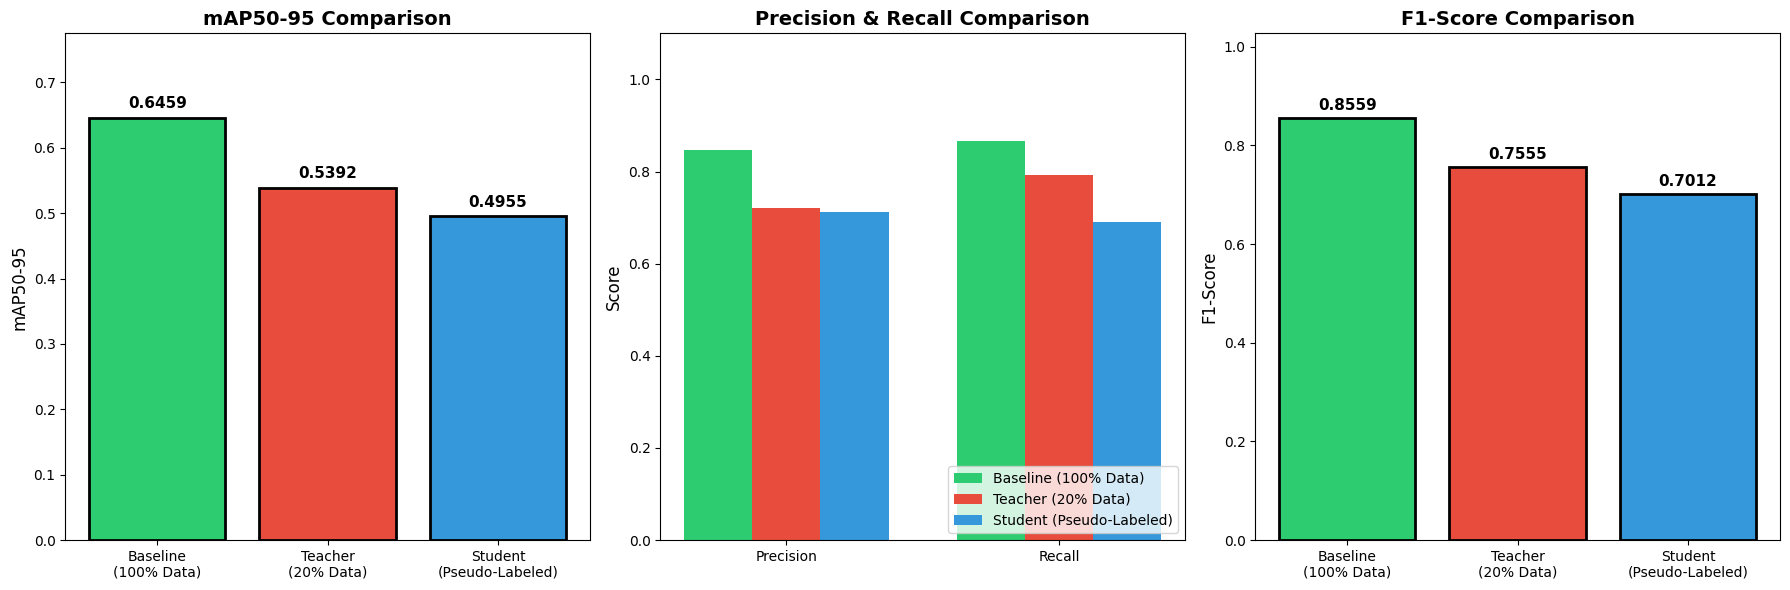

In [17]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = ['Baseline\n(100% Data)', f'Teacher\n({LABELED_RATIO*100:.0f}% Data)', 'Student\n(Pseudo-Labeled)']
colors = ['#2ecc71', '#e74c3c', '#3498db']

# mAP50-95 comparison
map_values = [baseline_res['mAP50-95'], teacher_res['mAP50-95'], student_res['mAP50-95']]
bars = axes[0].bar(models, map_values, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('mAP50-95', fontsize=12)
axes[0].set_title('mAP50-95 Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(map_values) * 1.2)
for bar, val in zip(bars, map_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.4f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# Precision-Recall comparison
x = np.arange(2)
width = 0.25
precision_vals = [baseline_res['Precision'], teacher_res['Precision'], student_res['Precision']]
recall_vals = [baseline_res['Recall'], teacher_res['Recall'], student_res['Recall']]

for i, (model, color) in enumerate(zip(models, colors)):
    axes[1].bar(x + i*width, [precision_vals[i], recall_vals[i]], width, label=model.replace('\n', ' '), color=color)

axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Precision & Recall Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(['Precision', 'Recall'])
axes[1].legend(loc='lower right')
axes[1].set_ylim(0, 1.1)

# F1-Score comparison
f1_values = [baseline_res['F1-Score'], teacher_res['F1-Score'], student_res['F1-Score']]
bars = axes[2].bar(models, f1_values, color=colors, edgecolor='black', linewidth=2)
axes[2].set_ylabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylim(0, max(f1_values) * 1.2)
for bar, val in zip(bars, f1_values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.4f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(str(EXPERIMENT_DIR / 'model_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

📁 Using images from: /kaggle/input/brain-mri-split-dataset-v2/brain-mri-split-dataset-v2/dataset/test/images
📊 Found 227 test images

🖼️ Visualizing model predictions with detection counts...
✅ Saved: /kaggle/working/ssod_yolov12/teacher_yolov12_predictions_counts.png


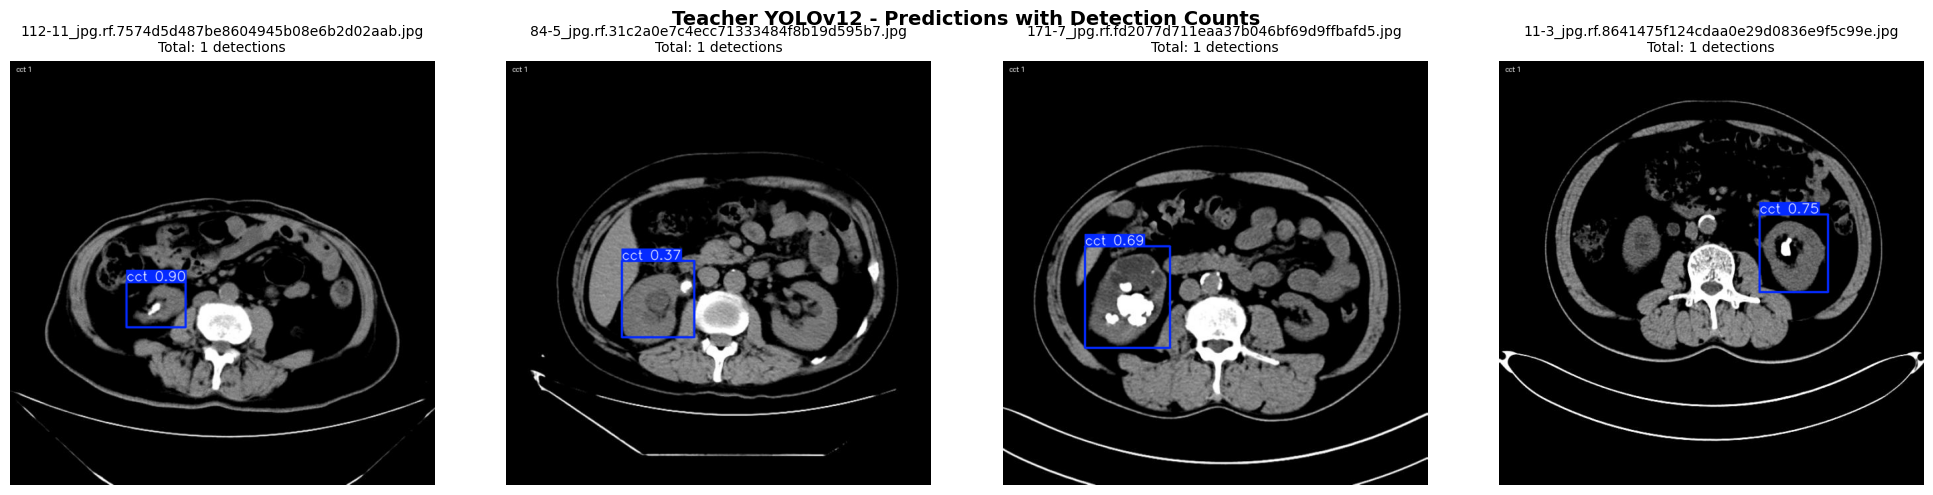

✅ Saved: /kaggle/working/ssod_yolov12/student_yolov12_predictions_counts.png


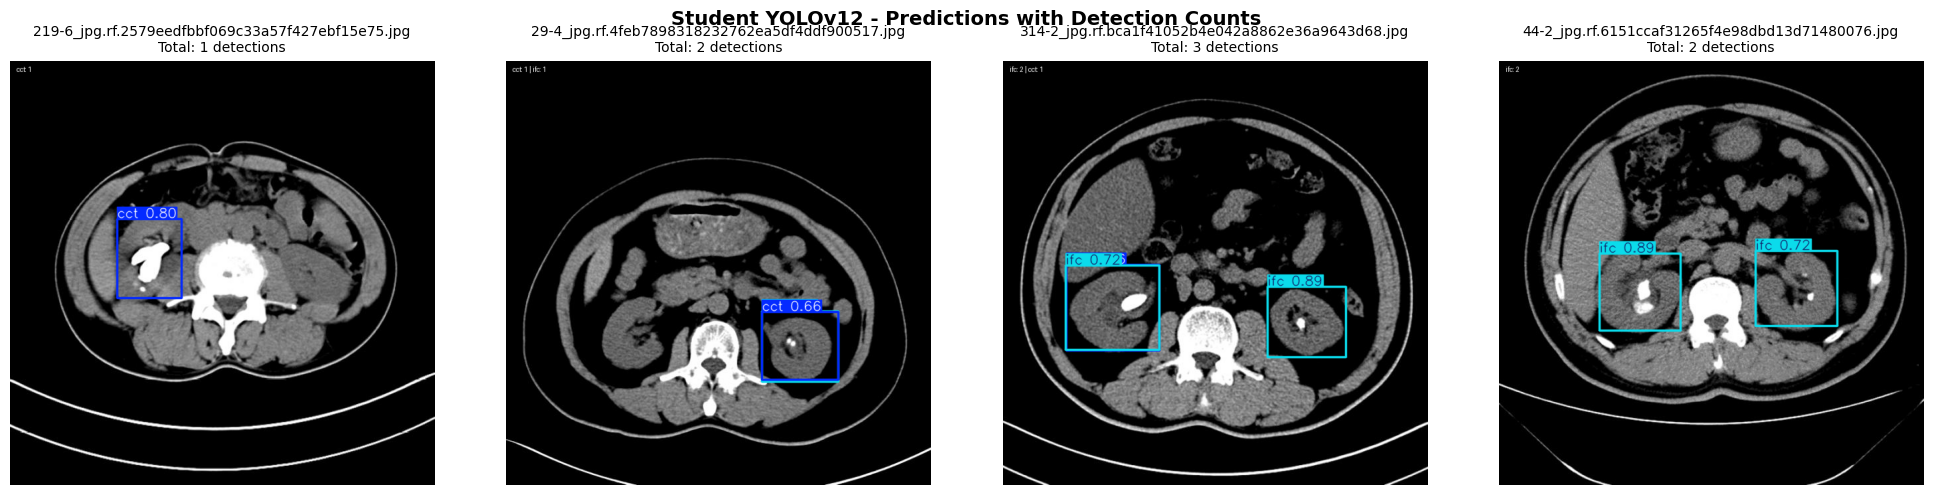

✅ Saved: /kaggle/working/ssod_yolov12/baseline_yolov12_predictions_counts.png


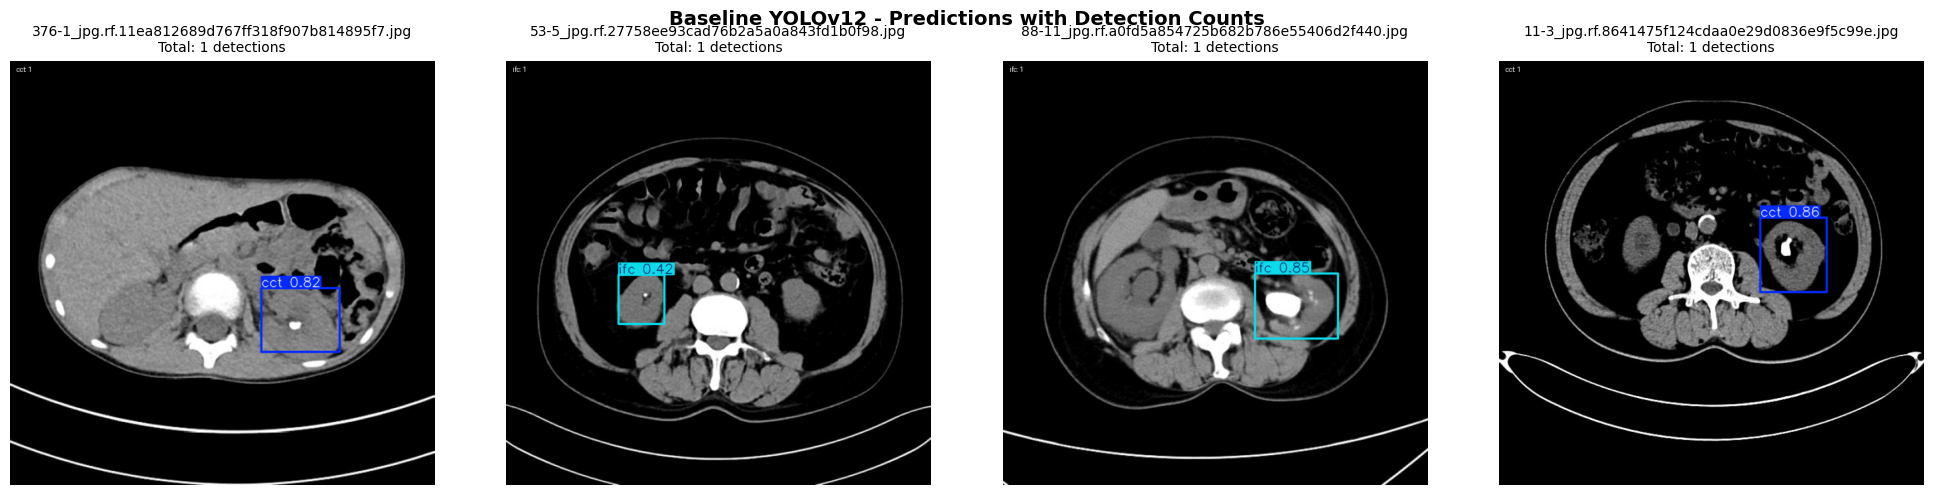

In [18]:
# ============================================
# ENHANCED VISUALIZATION WITH DETECTION COUNTS
# ============================================
def visualize_predictions_with_counts(model, model_name, test_images, num_samples=4):
    """Visualize model predictions with bounding boxes and detection counts (like teacher's example)."""
    if len(test_images) == 0:
        print(f"⚠️ No test images found for {model_name}")
        return
    
    samples = random.sample(test_images, min(num_samples, len(test_images)))
    
    fig, axes = plt.subplots(1, len(samples), figsize=(5*len(samples), 5))
    if len(samples) == 1:
        axes = [axes]
    
    for idx, img_path in enumerate(samples):
        results = model.predict(source=str(img_path), conf=0.25, verbose=False)
        
        # Count detections per class
        boxes = results[0].boxes
        detection_counts = Counter()
        for box in boxes:
            cls_id = int(box.cls[0])
            cls_name = CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else f"class_{cls_id}"
            detection_counts[cls_name] += 1
        
        # Get annotated image with bounding boxes
        annotated = results[0].plot()
        annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL for text overlay
        pil_img = Image.fromarray(annotated)
        draw = ImageDraw.Draw(pil_img)
        
        # Add detection count text overlay
        try:
            font = ImageFont.truetype("DejaVuSans-Bold.ttf", 24)
        except:
            font = ImageFont.load_default()
        
        count_text = " | ".join([f"{cls}: {cnt}" for cls, cnt in detection_counts.items()])
        if not count_text:
            count_text = "No detections"
        
        # Draw background rectangle for text
        text_bbox = draw.textbbox((0, 0), count_text, font=font)
        text_w, text_h = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
        draw.rectangle([(5, 5), (text_w + 15, text_h + 15)], fill=(0, 0, 0, 180))
        draw.text((10, 8), count_text, fill="white", font=font)
        
        axes[idx].imshow(np.array(pil_img))
        axes[idx].set_title(f'{img_path.name}\nTotal: {len(boxes)} detections', fontsize=10)
        axes[idx].axis('off')
    
    plt.suptitle(f'{model_name} - Predictions with Detection Counts', fontsize=14, fontweight='bold')
    plt.tight_layout()
    save_path = EXPERIMENT_DIR / f'{model_name.lower().replace(" ", "_")}_predictions_counts.png'
    plt.savefig(str(save_path), dpi=150, bbox_inches='tight')
    print(f"✅ Saved: {save_path}")
    plt.show()
    plt.close()

# ============================================
# GET TEST IMAGES FROM CORRECT PATHS
# ============================================

# Use original test directory
test_img_dir = BASE_DIR / 'test' / 'images'

# Fallback to validation if test doesn't exist
if not test_img_dir.exists():
    print("⚠️ Test directory not found, using validation set")
    test_img_dir = BASE_DIR / 'valid' / 'images'
    if not test_img_dir.exists():
        test_img_dir = BASE_DIR / 'val' / 'images'

print(f"📁 Using images from: {test_img_dir}")

# Get test images
test_images = list(test_img_dir.glob('*.jpg')) + list(test_img_dir.glob('*.png'))
print(f"📊 Found {len(test_images)} test images")

if len(test_images) == 0:
    print("❌ No test images found! Check your dataset structure.")
else:
    print("\n🖼️ Visualizing model predictions with detection counts...")
    visualize_predictions_with_counts(teacher_model, 'Teacher YOLOv12', test_images)
    visualize_predictions_with_counts(student_model, 'Student YOLOv12', test_images)
    visualize_predictions_with_counts(baseline_model, 'Baseline YOLOv12', test_images)


### 10.2 Confusion Matrix & Training Curves

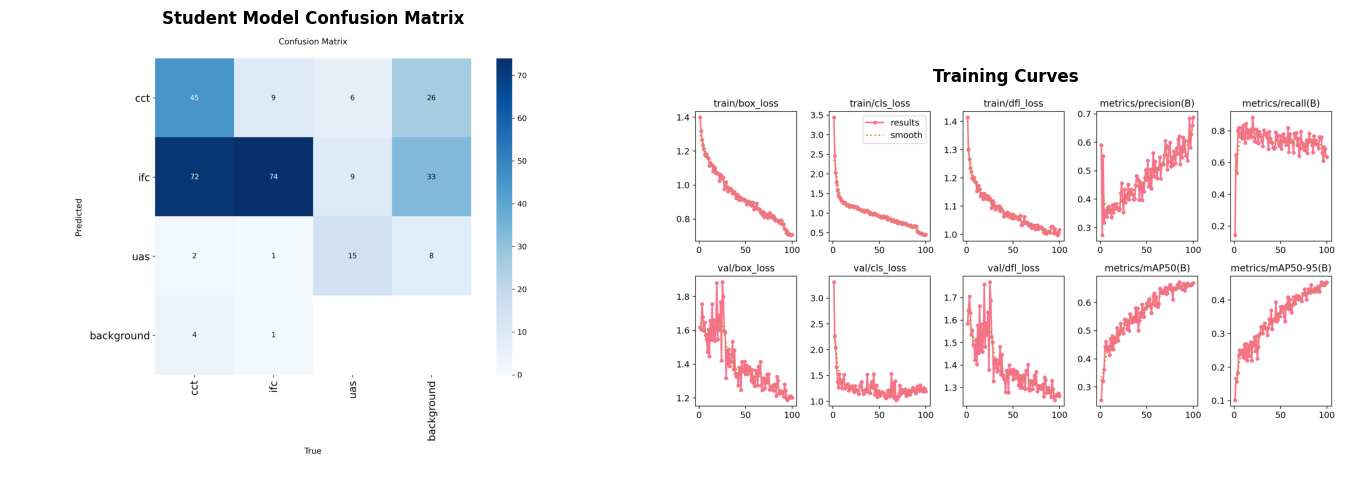


📊 Training Progress (Last 5 Epochs):
    epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
95     96  1365.16         0.70855         0.47039         1.00447   
96     97  1378.81         0.70942         0.45297         1.00546   
97     98  1392.74         0.70758         0.44891         0.99721   
98     99  1406.47         0.70474         0.43592         1.00401   
99    100  1420.37         0.70917         0.44850         1.01674   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
95               0.68363            0.61120           0.66356   
96               0.58125            0.69788           0.66093   
97               0.62787            0.68597           0.66135   
98               0.65893            0.63982           0.66704   
99               0.68821            0.63498           0.66980   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
95              0.44815       1.19495       1.23844       1.26170  0.00

In [19]:
# ============================================
# CONFUSION MATRIX AND TRAINING CURVES
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Load and display confusion matrix if exists
cm_path = EXPERIMENT_DIR / 'student_model' / 'confusion_matrix.png'
if cm_path.exists():
    cm_img = plt.imread(cm_path)
    axes[0].imshow(cm_img)
    axes[0].set_title('Student Model Confusion Matrix', fontweight='bold')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'Confusion matrix not found\nRun training first', 
                 ha='center', va='center', fontsize=12)
    axes[0].set_title('Confusion Matrix', fontweight='bold')
    axes[0].axis('off')

# Load and display training curves if exists
results_path = EXPERIMENT_DIR / 'student_model' / 'results.png'
if results_path.exists():
    results_img = plt.imread(results_path)
    axes[1].imshow(results_img)
    axes[1].set_title('Training Curves', fontweight='bold')
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'Training curves not found\nRun training first', 
                 ha='center', va='center', fontsize=12)
    axes[1].set_title('Training Curves', fontweight='bold')
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(str(EXPERIMENT_DIR / 'training_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

# Load results CSV if exists
results_csv = EXPERIMENT_DIR / 'student_model' / 'results.csv'
if results_csv.exists():
    print("\n📊 Training Progress (Last 5 Epochs):")
    df = pd.read_csv(results_csv)
    print(df.tail())
else:
    print("\n⚠️ Training results CSV not found. Run training first.")


## 11. Conclusion

### Summary

In [20]:
# Final summary
print("="*70)
print("📋 EXPERIMENT SUMMARY - YOLOv12 SSOD with Pseudo-Labelling")
print("="*70)
print(f"""
Semi-Supervised Object Detection using Pseudo-Labelling with YOLOv12

📊 DATASET:
   - Total Training Images: {len(all_train_images)}
   - Labeled (Teacher): {len(labeled_images)} ({LABELED_RATIO*100:.0f}%)
   - Unlabeled: {len(unlabeled_images)} ({(1-LABELED_RATIO)*100:.0f}%)
   - Pseudo-Labeled: {pseudo_stats['images_with_detections']}

📈 RESULTS (mAP50-95):
   - Baseline (100% Data):      {baseline_res['mAP50-95']:.4f}
   - Teacher ({LABELED_RATIO*100:.0f}% Data):       {teacher_res['mAP50-95']:.4f}
   - Student (Pseudo-Labeled):  {student_res['mAP50-95']:.4f}

🎯 KEY FINDINGS:
   - Pre-trained YOLOv12 weights from Assignment 1 provided strong initialization
   - Pseudo-labelling improved mAP by {improvement_over_teacher:+.2f}% over teacher
   - Student recovered {100-gap_to_baseline:.1f}% of the performance gap to baseline
   - Pseudo-labels generated: {pseudo_stats['total_detections']}
   - Average pseudo-label confidence: {np.mean(pseudo_stats['confidence_scores']):.4f}

✅ STAC-style pseudo-labelling with YOLOv12 successfully leveraged 
   unlabeled data to improve model performance.
""")
print("="*70)

# Save results
results_df.to_csv(str(EXPERIMENT_DIR / 'final_results.csv'), index=False)
print(f"\n💾 Results saved to {EXPERIMENT_DIR / 'final_results.csv'}")

📋 EXPERIMENT SUMMARY - YOLOv12 SSOD with Pseudo-Labelling

Semi-Supervised Object Detection using Pseudo-Labelling with YOLOv12

📊 DATASET:
   - Total Training Images: 1810
   - Labeled (Teacher): 362 (20%)
   - Unlabeled: 1448 (80%)
   - Pseudo-Labeled: 846

📈 RESULTS (mAP50-95):
   - Baseline (100% Data):      0.6459
   - Teacher (20% Data):       0.5392
   - Student (Pseudo-Labeled):  0.4955

🎯 KEY FINDINGS:
   - Pre-trained YOLOv12 weights from Assignment 1 provided strong initialization
   - Pseudo-labelling improved mAP by -8.11% over teacher
   - Student recovered 76.7% of the performance gap to baseline
   - Pseudo-labels generated: 899
   - Average pseudo-label confidence: 0.8806

✅ STAC-style pseudo-labelling with YOLOv12 successfully leveraged 
   unlabeled data to improve model performance.


💾 Results saved to /kaggle/working/ssod_yolov12/final_results.csv
